# GRU Model

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from numerical_preprocessing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

### Load Dataset and Select Ticker

In [3]:
df = pd.read_csv("stock_yfinance_data.csv")

ticker = 'TSLA'
df = clean_stock_data(df, ticker=ticker)

df.head()

,date,open,high,low,close,adj_close,volume
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400


### Calculate technical analysis features

In [4]:
df['rdr'] = relative_daily_range(df)
df['sma'] = simple_moving_average(df)
df['ema'] = exponential_moving_average(df)
df['rsi'] = calculate_rsi(df)
df['macd_line'] , df['macd_signal'], df['macd'] = calculate_macd(df)
df['bb_middle'], df['bb_upper'], df['bb_lower'] = bollinger_bands(df)
df.dropna(inplace=True)
df.head()

,date,open,high,low,close,adj_close,volume,rdr,sma,ema,rsi,macd_line,macd_signal,macd,bb_middle,bb_upper,bb_lower
19,2021-10-27,346.553345,356.959991,343.593323,345.953339,345.953339,115579500,0.121020,283.829501,293.487203,92.846316,18.892766,11.140409,7.752357,283.829501,341.251886,226.407117
20,2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,0.080881,288.855501,299.727787,96.118171,21.687444,13.249816,8.437628,288.855501,354.015698,223.695304
21,2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,0.122811,294.501834,306.547364,96.459875,24.612650,15.522383,9.090267,294.501834,367.635649,221.368019
22,2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,0.208668,301.619501,315.720314,97.129203,29.139205,18.245747,10.893457,301.619501,387.433479,215.805523
23,2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,0.143381,308.143001,322.858061,89.346741,31.380625,20.872723,10.507902,308.143001,400.300312,215.985690


### Normalize features based on moving window

In [5]:
feature_col = ['open', 'high', 'low', 'close', 'volume', 'rdr', 'sma', 'ema', 'rsi', 'macd']
norm_df = pd.DataFrame({})
window = 30 #days

for col in feature_col:
    norm_df[col] = calculate_moving_normalized(df, col, window)

norm_df = norm_df.iloc[window:].reset_index(drop=True)
norm_df

,open,high,low,close,volume,rdr,sma,ema,rsi,macd
0,0.253886,0.184133,0.194596,0.000000,0.171469,0.469399,0.836295,0.874582,0.056990,0.091122
1,0.031086,0.000000,0.120188,0.058511,0.173057,0.246865,0.814693,0.832022,0.000000,0.097195
2,0.000000,0.000000,0.003452,0.000000,0.306118,0.402166,0.780642,0.736376,0.000000,0.055355
3,0.000000,0.000000,0.000000,0.000000,0.251370,0.197753,0.744560,0.616433,0.045706,0.037074
4,0.028368,0.044536,0.000000,0.064407,0.282035,0.328413,0.690125,0.459921,0.072020,0.064626
...,...,...,...,...,...,...,...,...,...,...
198,0.268890,0.220030,0.177711,0.130913,0.460763,0.492524,0.575938,0.824818,0.670916,0.458126
199,0.000000,0.209429,0.114709,0.148300,0.341349,0.624178,0.422977,0.648564,0.638954,0.312073
200,0.301481,0.327847,0.295432,0.327586,0.433537,0.459925,0.245138,0.560669,0.618639,0.304625
201,0.308557,0.344089,0.296938,0.452908,0.283043,0.476851,0.064204,0.536218,0.611746,0.365305


### Plot Stock Price

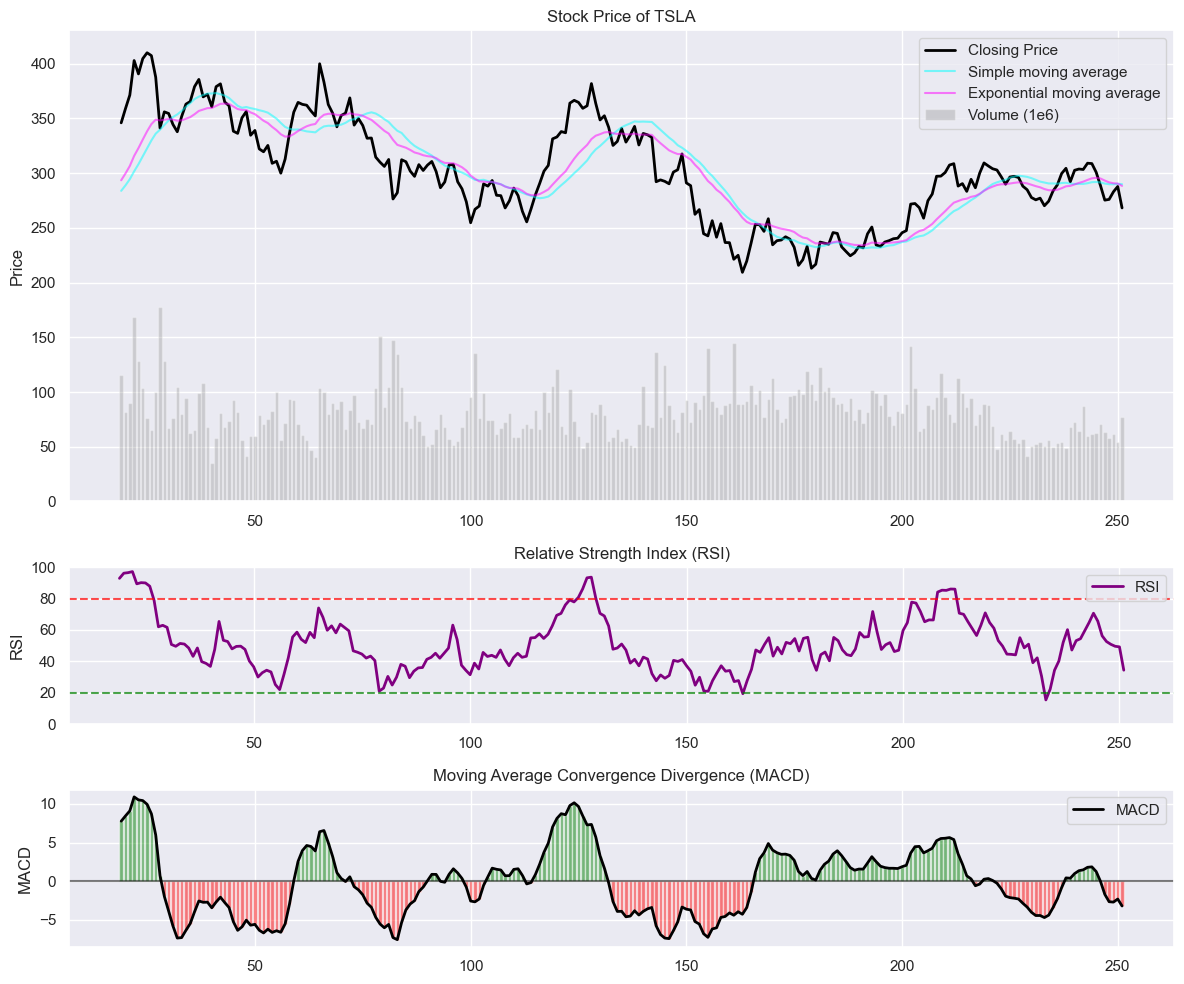

In [6]:
fig, axs = plt.subplots(3, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1, 1]})

# Plot stock price with volume
vol_scale = 1e6
axs[0].bar(df.index, df['volume']/vol_scale, label=f"Volume (1e{int(np.log10(vol_scale))})", color='grey', alpha=0.3)
axs[0].plot(df.index, df['close'], label="Closing Price", color='black', linewidth=2)
axs[0].plot(df.index, df['sma'], label="Simple moving average", color='cyan', alpha=0.5)
axs[0].plot(df.index, df['ema'], label="Exponential moving average", color='magenta', alpha=0.5)
axs[0].set_title(f"Stock Price of {ticker}")
axs[0].set_ylabel("Price")
axs[0].legend(loc="upper right")

# Plot RSI
axs[1].plot(df.index, df['rsi'], label="RSI", color='purple', linewidth=2)
axs[1].axhline(80, linestyle='dashed', color='red', alpha=0.7)
axs[1].axhline(20, linestyle='dashed', color='green', alpha=0.7)
axs[1].set_title("Relative Strength Index (RSI)")
axs[1].set_ylabel("RSI")
axs[1].set_ylim([0,100])
axs[1].legend(loc="upper right")

# Plot MACD
axs[2].plot(df.index, df['macd'], label="MACD", color='black', linewidth=2)
axs[2].bar(df.index, df['macd'], 
           color=['green' if v >= 0 else 'red' for v in df['macd']], 
           alpha=0.5)
axs[2].axhline(0, color='black', alpha=0.5)
axs[2].set_title("Moving Average Convergence Divergence (MACD)")
axs[2].set_ylabel("MACD")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Plot Normalized Features

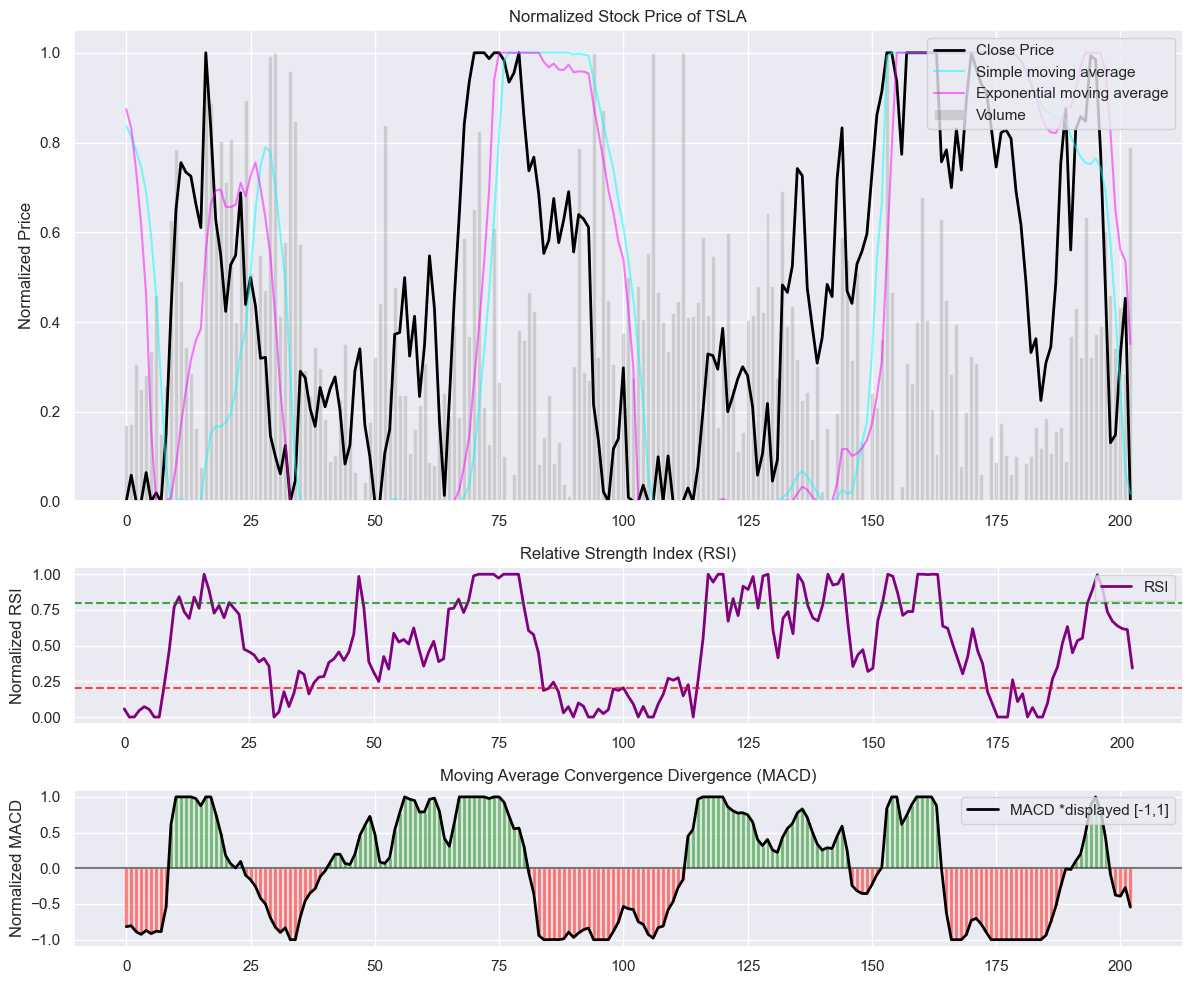

In [7]:
fig, axs = plt.subplots(3, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1, 1]})

# Plot stock price with volume
axs[0].bar(norm_df.index, norm_df['volume'], label=f"Volume", color='grey', alpha=0.3)
axs[0].plot(norm_df.index, norm_df['close'], label="Close Price", color='black', linewidth=2)
axs[0].plot(norm_df.index, norm_df['sma'], label="Simple moving average", color='cyan', alpha=0.5)
axs[0].plot(norm_df.index, norm_df['ema'], label="Exponential moving average", color='magenta', alpha=0.5)
axs[0].set_title(f"Normalized Stock Price of {ticker}")
axs[0].set_ylabel("Normalized Price")
axs[0].legend(loc="upper right")

# Plot RSI
axs[1].plot(norm_df.index, norm_df['rsi'], label="RSI", color='purple', linewidth=2)
axs[1].axhline(0.2, linestyle='dashed', color='red', alpha=0.7)
axs[1].axhline(0.8, linestyle='dashed', color='green', alpha=0.7)
axs[1].set_title("Relative Strength Index (RSI)")
axs[1].set_ylabel("Normalized RSI")
axs[1].legend(loc="upper right")

# Plot MACD
axs[2].plot(norm_df.index, 2*(norm_df['macd']-0.5), label="MACD *displayed [-1,1]", color='black', linewidth=2)
axs[2].bar(norm_df.index, 2*(norm_df['macd']-0.5), 
           color=['green' if v >= 0 else 'red' for v in 2*(norm_df['macd']-0.5)], 
           alpha=0.5)
axs[2].axhline(0, color='black', alpha=0.5)
axs[2].set_title("Moving Average Convergence Divergence (MACD)")
axs[2].set_ylabel("Normalized MACD")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

### Calculate target value

In [8]:
norm_df['target'] = calculate_closing_diff(norm_df)
norm_df

,open,high,low,close,volume,rdr,sma,ema,rsi,macd,target
0,0.253886,0.184133,0.194596,0.000000,0.171469,0.469399,0.836295,0.874582,0.056990,0.091122,0.000000
1,0.031086,0.000000,0.120188,0.058511,0.173057,0.246865,0.814693,0.832022,0.000000,0.097195,0.058511
2,0.000000,0.000000,0.003452,0.000000,0.306118,0.402166,0.780642,0.736376,0.000000,0.055355,-0.058511
3,0.000000,0.000000,0.000000,0.000000,0.251370,0.197753,0.744560,0.616433,0.045706,0.037074,0.000000
4,0.028368,0.044536,0.000000,0.064407,0.282035,0.328413,0.690125,0.459921,0.072020,0.064626,0.064407
...,...,...,...,...,...,...,...,...,...,...,...
198,0.268890,0.220030,0.177711,0.130913,0.460763,0.492524,0.575938,0.824818,0.670916,0.458126,-0.339044
199,0.000000,0.209429,0.114709,0.148300,0.341349,0.624178,0.422977,0.648564,0.638954,0.312073,0.017387
200,0.301481,0.327847,0.295432,0.327586,0.433537,0.459925,0.245138,0.560669,0.618639,0.304625,0.179286
201,0.308557,0.344089,0.296938,0.452908,0.283043,0.476851,0.064204,0.536218,0.611746,0.365305,0.125321


### Split train & test sets

In [9]:
current_day = -1 #predict closing delta
prev_days = 20
data = norm_df.to_numpy()
data_x, data_y = generate_model_data(data, sequence_size=prev_days, target_idx=current_day)
print('Model Data')
print("------------------------------------")
print("> Data X: " + str(data_x.shape))
print("> Data y: " + str(data_y.shape))
print()

test_size = 30
data_x_train = data_x[:-test_size]
data_y_train = data_y[:-test_size]
print('Train Set')
print("------------------------------------")
print("> Data X: " + str(data_x_train.shape))
print("> Data y: " + str(data_y_train.shape))
print()


data_x_test = data_x[-test_size:]
data_y_test = data_y[-test_size:]
print('Test Set')
print("------------------------------------")
print("> Data X: " + str(data_x_test.shape))
print("> Data y: " + str(data_y_test.shape))

Model Data
------------------------------------
> Data X: (182, 20, 11)
> Data y: (182, 1)

Train Set
------------------------------------
> Data X: (152, 20, 11)
> Data y: (152, 1)

Test Set
------------------------------------
> Data X: (30, 20, 11)
> Data y: (30, 1)


### Define Model

In [10]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [19]:
num_layers = 5
hidden_dim = 128
output_size = 1  # Predicting next-day stock price
dropout_rate = 0.1

model = GRU_Model(num_layers, hidden_dim, output_size, dropout_rate)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    x = data_x_train,
    y = data_y_train,
    epochs=50,
    batch_size=128,
    validation_data=(data_x_test, data_y_test)
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0263 - mae: 0.1189 - val_loss: 0.0424 - val_mae: 0.1816
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 670ms/step - loss: 0.0214 - mae: 0.1190 - val_loss: 0.0404 - val_mae: 0.1606
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step - loss: 0.0251 - mae: 0.1238 - val_loss: 0.0248 - val_mae: 0.1213
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step - loss: 0.0202 - mae: 0.1126 - val_loss: 0.0232 - val_mae: 0.1209
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - loss: 0.0208 - mae: 0.1141 - val_loss: 0.0241 - val_mae: 0.1198
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - loss: 0.0152 - mae: 0.0931 - val_loss: 0.0253 - val_mae: 0.1224
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - loss: 0.0167 - mae: 0.0975 - val_loss: 0.0234 - val_mae: 0.1173
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.0156 - mae: 0.0929 - val_loss: 0.0237 - val_mae: 0.1237
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - loss: 0.0148 - mae: 0.

### Plot Performance

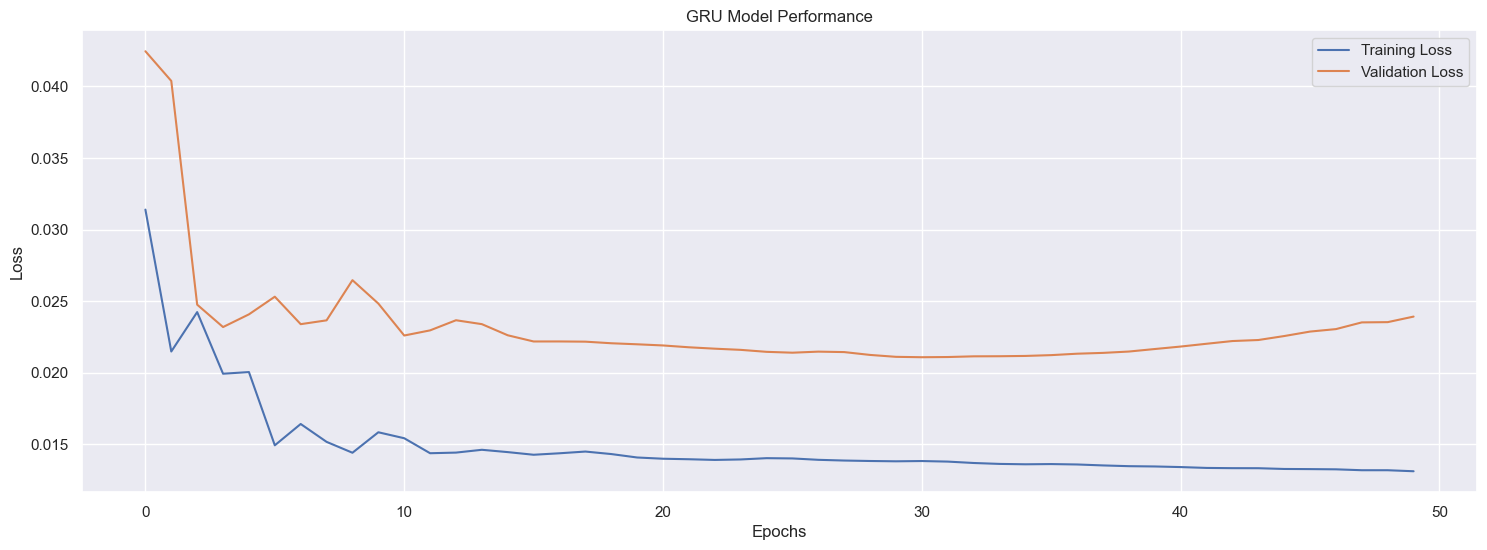

In [20]:
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step


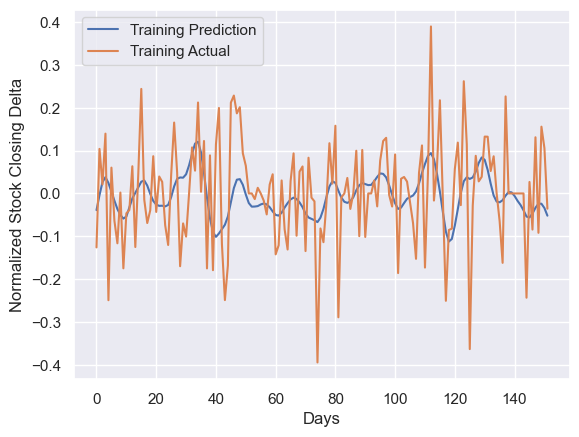

In [21]:
train_predictions = model.predict(data_x_train)
train_actual = data_y_train
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

In [22]:
diff = np.sign(train_predictions.flatten())-np.sign(train_actual.flatten())
thresh = np.max(np.abs(train_predictions))/2
significant = np.where(np.abs(train_predictions.flatten()) > thresh)
print('We perform predictions for ' + str(len(diff)) + ' days')
print('Let a significant day be a day where the absolute value of the predicted closing delta is greater than ' + str(thresh))
print('There are ' + str(len(significant[0])) + ' such events')
print('Of those events, we predict ' + str(np.count_nonzero(diff[significant])) + ' incorrectly')

We perform predictions for 152 days
Let a significant day be a day where the absolute value of the predicted closing delta is greater than 0.060312383
There are 23 such events
Of those events, we predict 6 incorrectly


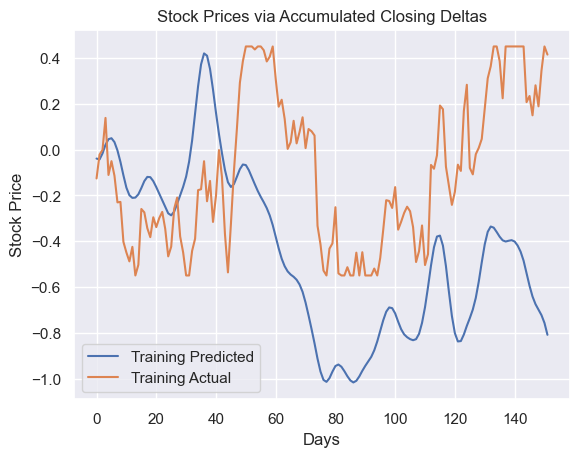

In [23]:
stock_price_train_pred = np.cumsum(train_predictions)
stock_price_train_actual = np.cumsum(train_actual)
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()

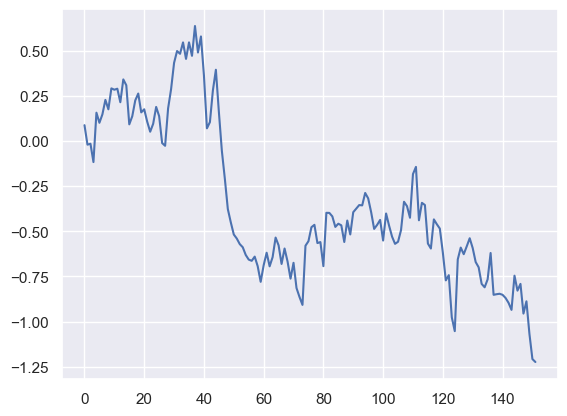

In [24]:
diff2 = stock_price_train_pred - stock_price_train_actual
plt.plot(diff2)

### Test Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


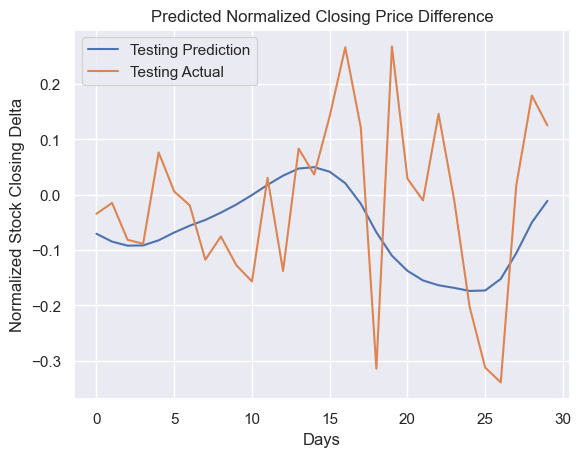

In [25]:
test_predictions = model.predict(data_x_test)
test_actual = data_y_test
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.title("Predicted Normalized Closing Price Difference")
plt.legend()

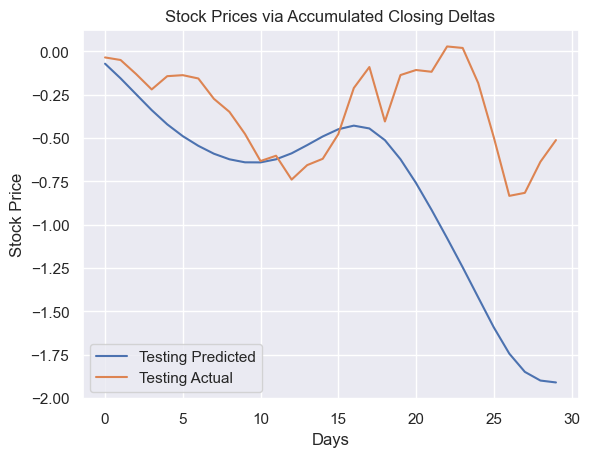

In [26]:
stock_price_test_pred = np.cumsum(test_predictions)
stock_price_test_actual = np.cumsum(test_actual)
plt.plot(stock_price_test_pred, label='Testing Predicted')
plt.plot(stock_price_test_actual, label='Testing Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()